In [22]:
import cv2
import numpy as np
from insightface.app import FaceAnalysis
from scipy.spatial import procrustes
from PIL import Image, ImageDraw, ImageFont

In [23]:
def process_image_for_faces(image_path):
    app = FaceAnalysis(allowed_modules=["detection", "landmark_2d_106"], providers=["CUDAExecutionProvider"])
    app.prepare(ctx_id=0, det_size=(640, 640))

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or unable to load.")
    
    faces_data = app.get(img)
    faces_landmarks = []
    bounding_boxes = []
    
    for face in faces_data:
        if "landmark_2d_106" in face:
            lmk = face["landmark_2d_106"]
            bbox = face["bbox"].astype(np.int64)
            faces_landmarks.append(np.round(lmk).astype(np.int64))
            bounding_boxes.append(bbox)
    
    return faces_landmarks, bounding_boxes, img

In [25]:
def calculate_percentages(landmarks):
    percentages = {}

    # Define face width as the reference length for normalization
    face_width = np.linalg.norm(landmarks[1] - landmarks[17])

    # Calculate distances and convert them to percentages of the face width
    percentages["left_eyebrow"] = (
        100 * np.linalg.norm(landmarks[43] - landmarks[50]) / face_width
    )
    percentages["right_eyebrow"] = (
        100 * np.linalg.norm(landmarks[101] - landmarks[102]) / face_width
    )
    percentages["left_eye"] = (
        100 * np.linalg.norm(landmarks[35] - landmarks[39]) / face_width
    )
    percentages["right_eye"] = (
        100 * np.linalg.norm(landmarks[93] - landmarks[89]) / face_width
    )
    percentages["nose_height"] = (
        100 * np.linalg.norm(landmarks[72] - landmarks[80]) / face_width
    )
    percentages["face_width"] = 100  # By definition, this is 100%
    percentages["lip_width"] = (
        100 * np.linalg.norm(landmarks[52] - landmarks[61]) / face_width
    )
    percentages["upper_lip_height"] = (
        100 * np.linalg.norm(landmarks[71] - landmarks[62]) / face_width
    )
    percentages["lower_lip_height"] = (
        100 * np.linalg.norm(landmarks[60] - landmarks[53]) / face_width
    )
    percentages["eye_to_eye"] = (
        100 * np.linalg.norm(landmarks[35] - landmarks[93]) / face_width
    )

    return percentages

In [26]:
def compare_faces_landmarks_between_two_sets(landmarks1, landmarks2):
    results = []
    print("Procrustes disparity results for face matches between two sets:")
    for idx1, lmk1 in enumerate(landmarks1):
        for idx2, lmk2 in enumerate(landmarks2):
            mtx1, mtx2, disparity = procrustes(lmk1, lmk2)
            results.append((idx1, idx2, disparity))
            print(
                f"Face {idx1} in Set 1 vs Face {idx2} in Set 2: Disparity = {disparity:.4f}"
            )
    return results

In [27]:
def compare_all_features(landmarks1, landmarks2):
    distances1 = calculate_percentages(landmarks1)
    distances2 = calculate_percentages(landmarks2)
    results = {}
    for key in distances1:
        # 각 특징 거리 차이를 비교
        disparity = abs(distances1[key] - distances2[key])
        results[key] = disparity
    return results

In [33]:
def draw_matching_faces(image1, landmarks1, bounding_boxes1, image2, landmarks2, bounding_boxes2, matches):
    pil_image1 = Image.fromarray(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    pil_image2 = Image.fromarray(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    draw1 = ImageDraw.Draw(pil_image1)
    draw2 = ImageDraw.Draw(pil_image2)

    # Load a font
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except IOError:
        font = ImageFont.load_default()

    color = (255, 0, 0)  # Set a color for the bounding box and landmarks
    point_radius = 2
    
    for idx1, (landmarks, bbox) in enumerate(zip(landmarks1, bounding_boxes1)):
        for point in landmarks:
            draw1.ellipse([point[0]-point_radius, point[1]-point_radius, point[0]+point_radius, point[1]+point_radius], fill=color)
        draw1.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], outline=color, width=2)
        draw1.text((bbox[0], bbox[1] - 20), f"Face {idx1}", fill=(255, 255, 255), font=font)
        
    for idx2, (landmarks, bbox) in enumerate(zip(landmarks2, bounding_boxes2)):
        for point in landmarks:
            draw2.ellipse([point[0]-point_radius, point[1]-point_radius, point[0]+point_radius, point[1]+point_radius], fill=color)
        draw2.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], outline=color, width=2)
        draw2.text((bbox[0], bbox[1] - 20), f"Face {idx2}", fill=(255, 255, 255), font=font)

    # Highlight matching faces with a different color
    match_color = (0, 255, 0)
    for match in matches:
        idx1, idx2, disparity = match
        if disparity < 0.05:  # Use the threshold you mentioned
            bbox1 = bounding_boxes1[idx1]
            bbox2 = bounding_boxes2[idx2]
            draw1.rectangle([bbox1[0], bbox1[1], bbox1[2], bbox1[3]], outline=match_color, width=3)
            draw2.rectangle([bbox2[0], bbox2[1], bbox2[2], bbox2[3]], outline=match_color, width=3)


    pil_image1.show()
    pil_image2.show()

In [34]:
# Paths to the images
img_path1 = "data/aespa1.jpg"
img_path2 = "data/winter_1.jpg"

landmarks1, boxes1, img1 = process_image_for_faces(img_path1)
landmarks2, boxes2, img2 = process_image_for_faces(img_path2)

if landmarks1 and landmarks2:
    comparison_results = compare_faces_landmarks_between_two_sets(landmarks1, landmarks2)
    draw_matching_faces(img1, landmarks1, boxes1, img2, landmarks2, boxes2, comparison_results)
else:
    print("Landmarks were not detected in one or both images.")

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\hancomtst/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hancomtst/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hancomtst/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\hancomtst/.insightface\models\buffalo_l\genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\hancomtst/.insightface\models\buffalo_l\w600k_r50.onnx recognition
set det-size: (640, 640)
Applied providers: ['CPUExecution

In [35]:
features_comparison = compare_all_features(landmarks1[0], landmarks2[0])
print("Feature disparities between two faces:")
for feature, disparity in features_comparison.items():
    print(f"{feature}: {disparity:.4f}")

Feature disparities between two faces:
left_eyebrow: 3.0242
right_eyebrow: 2.2910
left_eye: 0.0694
right_eye: 0.6441
nose_height: 8.9458
face_width: 0.0000
lip_width: 6.4688
upper_lip_height: 1.7076
lower_lip_height: 1.3134
eye_to_eye: 2.2973


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\hancomtst/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hancomtst/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\hancomtst/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\hancomtst/.insightface\models\buffalo_l\genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: C:\Users\hancomtst/.insightface\models\buffalo_l\w600k_r50.onnx recognition
set det-size: (640, 640)
Applied providers: ['CPUExecution

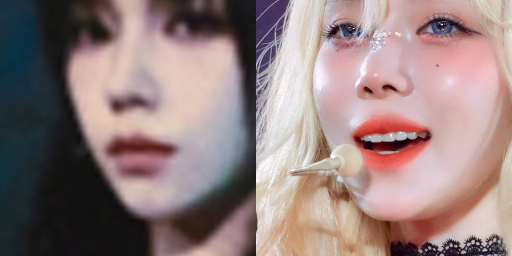

In [47]:
import cv2
import numpy as np
from insightface.app import FaceAnalysis
from scipy.spatial import procrustes
from PIL import Image
from IPython.display import display


def process_image_for_faces(image_path):
    app = FaceAnalysis(
        allowed_modules=["detection", "landmark_2d_106"],
        providers=["CUDAExecutionProvider"],
    )
    app.prepare(ctx_id=0, det_size=(640, 640))
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or unable to load.")
    faces_data = app.get(img)
    faces_landmarks = []
    bounding_boxes = []
    for face in faces_data:
        if "landmark_2d_106" in face:
            lmk = face["landmark_2d_106"]
            bbox = face["bbox"].astype(np.int64)
            faces_landmarks.append(np.round(lmk).astype(np.int64))
            bounding_boxes.append(bbox)
    return faces_landmarks, bounding_boxes, img


def normalize_face(image, landmarks):
    # Eye coordinates
    left_eye = landmarks[
        60
    ]  # Adjust these indices based on your landmark detection model
    right_eye = landmarks[
        72
    ]  # Adjust these indices based on your landmark detection model

    # Calculate the center point between the two eyes
    left_eye_center = np.array(left_eye, dtype=np.float32)
    right_eye_center = np.array(right_eye, dtype=np.float32)

    # Calculate the angle between the two eyes
    dY = right_eye_center[1] - left_eye_center[1]
    dX = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dY, dX)) + 90

    # Calculate the center between the eyes
    eye_center = (
        (left_eye_center[0] + right_eye_center[0]) / 2,
        (left_eye_center[1] + right_eye_center[1]) / 2,
    )

    # Desired face width and distance between eyes for normalization
    desired_face_width = 256
    desired_dist = desired_face_width * 0.5

    # Calculate the actual distance between the eyes to determine the scale factor
    dist = np.sqrt((dX**2) + (dY**2))
    scale = desired_dist / dist

    # Get the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D((int(eye_center[0]), int(eye_center[1])), angle, scale)

    # Update the translation component of the matrix
    tX = desired_face_width * 0.5
    tY = desired_face_width * 0.35
    M[0, 2] += tX - eye_center[0]
    M[1, 2] += tY - eye_center[1]

    # Apply the affine transformation
    (w, h) = (desired_face_width, desired_face_width)
    output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)

    return output


def compare_faces_landmarks_between_two_sets(landmarks1, landmarks2):
    results = []
    print("Procrustes disparity results for face matches between two sets:")
    for idx1, lmk1 in enumerate(landmarks1):
        for idx2, lmk2 in enumerate(landmarks2):
            mtx1, mtx2, disparity = procrustes(lmk1, lmk2)
            results.append((idx1, idx2, disparity))
            print(
                f"Face {idx1} in Set 1 vs Face {idx2} in Set 2: Disparity = {disparity:.4f}"
            )
    return results


def draw_matching_faces(
    image1, landmarks1, bounding_boxes1, image2, landmarks2, bounding_boxes2, matches
):
    for match in matches:
        idx1, idx2, disparity = match
        if disparity < 0.015:  # Use the threshold you mentioned
            # Normalize faces
            normalized_face1 = normalize_face(image1, landmarks1[idx1])
            normalized_face2 = normalize_face(image2, landmarks2[idx2])

            # Convert to PIL images
            pil_image1 = Image.fromarray(
                cv2.cvtColor(normalized_face1, cv2.COLOR_BGR2RGB)
            )
            pil_image2 = Image.fromarray(
                cv2.cvtColor(normalized_face2, cv2.COLOR_BGR2RGB)
            )

            # Create a new image that can fit both normalized faces side by side
            total_width = pil_image1.width + pil_image2.width
            max_height = max(pil_image1.height, pil_image2.height)

            new_image = Image.new("RGB", (total_width, max_height))
            new_image.paste(pil_image1, (0, 0))
            new_image.paste(pil_image2, (pil_image1.width, 0))

            # Display the new image
            display(
                new_image
            )  # Using display from IPython.display in Jupyter Notebooks


# Paths to the images
img_path1 = "data/aespa1.jpg"
img_path2 = "data/winter_1.jpg"

try:
    landmarks1, boxes1, img1 = process_image_for_faces(img_path1)
    landmarks2, boxes2, img2 = process_image_for_faces(img_path2)

    if landmarks1 and landmarks2:
        comparison_results = compare_faces_landmarks_between_two_sets(
            landmarks1, landmarks2
        )
        draw_matching_faces(
            img1, landmarks1, boxes1, img2, landmarks2, boxes2, comparison_results
        )
    else:
        print("Landmarks were not detected in one or both images.")
except Exception as e:
    print(f"An error occurred: {e}")